# Schema Design

This tutorial covers how to design DataJoint schemas effectively. You'll learn:

- **Table tiers** — Manual, Lookup, Imported, and Computed tables
- **Primary keys** — Uniquely identifying entities
- **Foreign keys** — Creating dependencies between tables
- **Relationship patterns** — One-to-many, one-to-one, and many-to-many

We'll build a schema for a neuroscience experiment tracking subjects, sessions, and trials.

In [1]:
import datajoint as dj

schema = dj.Schema('tutorial_design')

[2026-01-27 15:28:46] DataJoint 2.1.0a9 connected to postgres@127.0.0.1:5432


## Table Tiers

DataJoint has four table tiers, each serving a different purpose:

| Tier | Class | Purpose | Data Entry |
|------|-------|---------|------------|
| **Manual** | `dj.Manual` | Core experimental data | Inserted by operators or instruments |
| **Lookup** | `dj.Lookup` | Reference/configuration data | Pre-populated, rarely changes |
| **Imported** | `dj.Imported` | Data from external files | Auto-populated via `make()` |
| **Computed** | `dj.Computed` | Derived/processed data | Auto-populated via `make()` |

**Manual** tables are not necessarily populated by hand—they contain data entered into the pipeline by operators, instruments, or ingestion scripts using `insert` commands. In contrast, **Imported** and **Computed** tables are auto-populated by calling the `.populate()` method, which invokes the `make()` callback for each missing entry.

### Manual Tables

Manual tables store data that is inserted directly—the starting point of your pipeline.

In [2]:
@schema
class Lab(dj.Manual):
    definition = """
    # Research laboratory
    lab_id : varchar(16)            # short identifier (e.g., 'tolias')
    ---
    lab_name : varchar(100)
    institution : varchar(100)
    created_at = CURRENT_TIMESTAMP : datetime   # when record was created
    """

@schema
class Subject(dj.Manual):
    definition = """
    # Experimental subject
    subject_id : varchar(16)
    ---
    -> Lab
    species : varchar(50)
    date_of_birth : date
    sex : enum('M', 'F', 'U')
    """

### Lookup Tables

Lookup tables store reference data that rarely changes. Use the `contents` attribute to pre-populate them.

In [3]:
@schema
class TaskType(dj.Lookup):
    definition = """
    # Types of behavioral tasks
    task_type : varchar(32)
    ---
    description : varchar(255)
    """
    contents = [
        {'task_type': 'go_nogo', 'description': 'Go/No-Go discrimination task'},
        {'task_type': '2afc', 'description': 'Two-alternative forced choice'},
        {'task_type': 'foraging', 'description': 'Foraging/exploration task'},
    ]

@schema
class SessionStatus(dj.Lookup):
    definition = """
    # Session status codes
    status : varchar(16)
    """
    contents = [
        {'status': 'scheduled'},
        {'status': 'in_progress'},
        {'status': 'completed'},
        {'status': 'aborted'},
    ]

In [4]:
# Lookup tables are automatically populated
TaskType()

task_type,description
2afc,Two-alternative forced choice
foraging,Foraging/exploration task
go_nogo,Go/No-Go discrimination task


## Primary Keys

The **primary key** uniquely identifies each row. Attributes above the `---` line form the primary key.

### Design Principles

1. **Entity integrity** — Each row represents exactly one real-world entity
2. **No duplicates** — The primary key prevents inserting the same entity twice
3. **Minimal** — Include only attributes necessary for uniqueness

### Natural vs Surrogate Keys

- **Natural key**: An identifier used *outside* the database to refer to entities in the real world. Requires a real-world mechanism to establish and maintain the association (e.g., ear tags, cage labels, barcodes). Example: `subject_id = 'M001'` where M001 is printed on the animal's cage.

- **Surrogate key**: An identifier used *only inside* the database, with minimal or no exposure to end users. Users don't search by surrogate keys or use them in conversation. Example: internal record IDs, auto-generated UUIDs for system tracking.

DataJoint works well with both. Natural keys make data more interpretable and enable identification of physical entities. Surrogate keys are appropriate when entities exist only within the system or when natural identifiers shouldn't be stored (e.g., privacy).

In [5]:
@schema
class Session(dj.Manual):
    definition = """
    # Experimental session
    -> Subject
    session_idx : int32            # session number for this subject
    ---
    -> TaskType
    -> SessionStatus
    session_date : date
    session_notes = '' : varchar(1000)
    task_params = NULL : json       # task-specific parameters (nullable)
    """

    class Trial(dj.Part):
        definition = """
        # Individual trial within a session
        -> master
        trial_idx : int32
        ---
        stimulus : varchar(50)
        response : varchar(50)
        correct : bool
        reaction_time : decimal(3,2)  # seconds
        """

The primary key of `Session` is `(subject_id, session_idx)` — a **composite key**. This means:
- Each subject can have multiple sessions (1, 2, 3, ...)
- Session 1 for subject A is different from session 1 for subject B

## Foreign Keys

The `->` syntax creates a **foreign key** dependency. Foreign keys:

1. **Import attributes** — Primary key attributes are inherited from the parent
2. **Enforce referential integrity** — Can't insert a session for a non-existent subject
3. **Enable cascading deletes** — Deleting a subject removes all its sessions
4. **Define workflow** — The parent must exist before the child

In [6]:
# Let's insert some data to see how foreign keys work
Lab.insert1({
    'lab_id': 'tolias',
    'lab_name': 'Tolias Lab',
    'institution': 'Baylor College of Medicine'
})
# Note: created_at is auto-populated with CURRENT_TIMESTAMP

Subject.insert1({
    'subject_id': 'M001',
    'lab_id': 'tolias',
    'species': 'Mus musculus',
    'date_of_birth': '2026-01-15',
    'sex': 'M'
})

Subject()

subject_id,lab_id None,species,date_of_birth,sex
M001,tolias,Mus musculus,2026-01-15,M


In [7]:
# Insert sessions for this subject
Session.insert([
    {'subject_id': 'M001', 'session_idx': 1, 'task_type': 'go_nogo', 
     'status': 'completed', 'session_date': '2026-01-06',
     'task_params': {'go_probability': 0.5, 'timeout_sec': 2.0}},
    {'subject_id': 'M001', 'session_idx': 2, 'task_type': 'go_nogo',
     'status': 'completed', 'session_date': '2026-01-07',
     'task_params': {'go_probability': 0.7, 'timeout_sec': 1.5}},
    {'subject_id': 'M001', 'session_idx': 3, 'task_type': '2afc',
     'status': 'in_progress', 'session_date': '2026-01-08',
     'task_params': None},  # NULL - no parameters for this session
])

Session()

subject_id None,session_idx session number for this subject,task_type None,status None,session_date,session_notes,task_params task-specific parameters (nullable)
M001,1,go_nogo,completed,2026-01-06,,json
M001,2,go_nogo,completed,2026-01-07,,json
M001,3,2afc,in_progress,2026-01-08,,json


In [8]:
# This would fail - referential integrity prevents invalid foreign keys
try:
    Session.insert1({'subject_id': 'INVALID', 'session_idx': 1, 
                     'task_type': 'go_nogo', 'status': 'completed',
                     'session_date': '2026-01-06'})
except Exception as e:
    print(f"Error: {type(e).__name__}")
    print("Cannot insert session for non-existent subject!")

Error: IntegrityError
Cannot insert session for non-existent subject!


## Relationship Patterns

### One-to-Many (Hierarchical)

When a foreign key is part of the primary key, it creates a **one-to-many** relationship:
- One subject → many sessions
- One session → many trials

### Master-Part (Compositional Integrity)

A **part table** provides **compositional integrity**: master and parts are inserted and deleted as an atomic unit. Part tables:
- Reference the master with `-> master`
- Are inserted together with the master atomically
- Are deleted when the master is deleted
- Can be one-to-many or one-to-one with the master
- A master can have multiple part tables, which may reference each other

We defined `Session.Trial` as a part table because trials belong to their session:
- A session and all its trials should be entered together
- Deleting a session removes all its trials
- Downstream computations can assume all trials are present once the session exists

Use part tables when components must be complete before processing can begin.

In [9]:
# Access the part table
Session.Trial()

subject_id None,session_idx None,trial_idx,stimulus,response,correct,reaction_time seconds


### One-to-One (Extension)

When the child's primary key exactly matches the parent's, it creates a **one-to-one** relationship. This is useful for:
- Extending a table with optional or computed data
- Separating computed results from source data

`SessionSummary` below has a one-to-one relationship with `Session`—each session has exactly one summary.

In [10]:
@schema
class SessionSummary(dj.Computed):
    definition = """
    # Summary statistics for a session
    -> Session
    ---
    num_trials : int32
    num_correct : int32
    accuracy : float32
    mean_reaction_time : float32
    """
    
    def make(self, key):
        correct_vals, rt_vals = (Session.Trial & key).to_arrays('correct', 'reaction_time')
        rt_vals = rt_vals.astype(float)  # convert decimal to float
        n_trials = len(correct_vals)
        n_correct = sum(correct_vals) if n_trials else 0

        self.insert1({
            **key,
            'num_trials': n_trials,
            'num_correct': n_correct,
            'accuracy': n_correct / n_trials if n_trials else 0.0,
            'mean_reaction_time': sum(rt_vals) / n_trials if n_trials else 0.0
        })

### Foreign Key Modifiers

Foreign keys support modifiers that change their behavior:

| Modifier | Syntax | Effect |
|----------|--------|--------|
| **Nullable** | `-> [nullable] Table` | Makes FK optional (can be NULL) |
| **Unique** | `-> [unique] Table` | Enforces one-to-one from child side |
| **Both** | `-> [nullable, unique] Table` | Optional one-to-one relationship |

**Rules:**
- `[nullable]` only allowed for secondary FKs (below `---`)
- `[unique]` allowed for both primary and secondary FKs
- Primary key attributes cannot be nullable

**Nullable unique behavior:** Multiple rows can have NULL values because SQL's UNIQUE constraint does not consider NULLs equal to each other.

In [11]:
@schema
class Experimenter(dj.Manual):
    definition = """
    # Lab member who runs experiments
    experimenter_id : uuid          # anonymized identifier
    ---
    full_name : varchar(100)
    email = '' : varchar(100)
    """

@schema
class SessionExperimenter(dj.Manual):
    definition = """
    # Links sessions to experimenters (optional)
    -> Session
    ---
    -> [nullable] Experimenter      # experimenter may be unknown
    """

### Many-to-Many (Association Tables)

For many-to-many relationships, create an association table with foreign keys to both parents:

In [12]:
@schema
class Protocol(dj.Lookup):
    definition = """
    # Experimental protocols
    protocol_id : varchar(32)
    ---
    protocol_name : varchar(100)
    version : varchar(16)
    """
    contents = [
        {'protocol_id': 'iacuc_2024_01', 'protocol_name': 'Mouse Behavior', 'version': '1.0'},
        {'protocol_id': 'iacuc_2024_02', 'protocol_name': 'Imaging Protocol', 'version': '2.1'},
    ]

@schema 
class SubjectProtocol(dj.Manual):
    definition = """
    # Protocols assigned to subjects (many-to-many)
    -> Subject
    -> Protocol
    ---
    assignment_date : date
    """

## View the Schema

DataJoint can visualize the schema as a diagram:

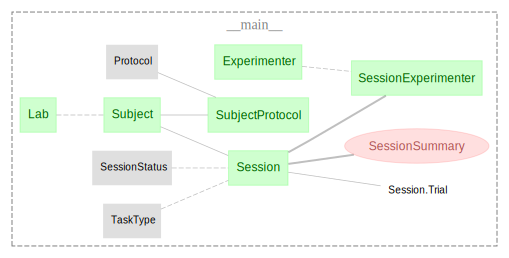

In [13]:
dj.Diagram(schema)

### Reading the Diagram

DataJoint diagrams show tables as nodes and foreign keys as edges. The notation conveys relationship semantics at a glance.

**Line Styles:**

| Line | Style | Relationship | Meaning |
|------|-------|--------------|---------|
| ━━━ | Thick solid | Extension | FK **is** entire PK (one-to-one) |
| ─── | Thin solid | Containment | FK **in** PK with other fields (one-to-many) |
| ┄┄┄ | Dashed | Reference | FK in secondary attributes (one-to-many) |

**Visual Indicators:**

| Indicator | Meaning |
|-----------|---------|
| **Underlined name** | Introduces new dimension (new PK attributes) |
| Non-underlined name | Inherits all dimensions (PK entirely from FKs) |
| **Green** | Manual table |
| **Gray** | Lookup table |
| **Red** | Computed table |
| **Blue** | Imported table |
| **Orange dots** | Renamed foreign keys (via `.proj()`) |

**Key principle:** Solid lines mean the parent's identity becomes part of the child's identity. Dashed lines mean the child maintains independent identity.

**Note:** Diagrams do NOT show `[nullable]` or `[unique]` modifiers—check table definitions for these constraints.

See [How to Read Diagrams](../../how-to/read-diagrams/) for diagram operations and comparison to ER notation.

## Insert Test Data and Populate

In [14]:
# Insert trials for the first session
import random
random.seed(42)

trials = []
for i in range(20):
    correct = random.random() > 0.3
    trials.append({
        'subject_id': 'M001',
        'session_idx': 1,
        'trial_idx': i + 1,
        'stimulus': random.choice(['left', 'right']),
        'response': random.choice(['go', 'nogo']),
        'correct': correct,
        'reaction_time': random.uniform(0.2, 0.8)
    })

Session.Trial.insert(trials, skip_duplicates=True)
print(f"Inserted {len(Session.Trial())} trials")

Inserted 20 trials


In [15]:
# Populate the computed summary
SessionSummary.populate(display_progress=True)
SessionSummary()

SessionSummary:   0%|          | 0/3 [00:00<?, ?it/s]

SessionSummary: 100%|██████████| 3/3 [00:00<00:00, 103.46it/s]

subject_id None,session_idx None,num_trials,num_correct,accuracy,mean_reaction_time
M001,1,20,14,0.7,0.5365
M001,2,0,0,0.0,0.0
M001,3,0,0,0.0,0.0


## Best Practices

### 1. Choose Meaningful Primary Keys
- Use natural identifiers when possible (`subject_id = 'M001'`)
- Keep keys minimal but sufficient for uniqueness

### 2. Use Appropriate Table Tiers
- **Manual**: Data entered by operators or instruments
- **Lookup**: Configuration, parameters, reference data
- **Imported**: Data read from files (recordings, images)
- **Computed**: Derived analyses and summaries

### 3. Normalize Your Data
- Don't repeat information across rows
- Create separate tables for distinct entities
- Use foreign keys to link related data

### 4. Use Core DataJoint Types

DataJoint has a three-layer type architecture (see [Type System Specification](../../reference/specs/type-system/)):

1. **Native database types** (Layer 1): Backend-specific types like `INT`, `FLOAT`, `TINYINT UNSIGNED`. These are **discouraged** but allowed for backward compatibility.

2. **Core DataJoint types** (Layer 2): Standardized, scientist-friendly types that work identically across MySQL and PostgreSQL. **Always prefer these.**

3. **Codec types** (Layer 3): Types with `encode()`/`decode()` semantics like `<blob>`, `<attach>`, `<object@>`.

**Core types used in this tutorial:**

| Type | Description | Example |
|------|-------------|---------|
| `int16`, `int32`, `int32` | Sized integers | `session_idx : int32` |
| `float32`, `float64` | Sized floats | `reaction_time : float32` |
| `varchar(n)` | Variable-length string | `name : varchar(100)` |
| `bool` | Boolean | `correct : bool` |
| `date` | Date only | `date_of_birth : date` |
| `datetime` | Date and time (UTC) | `created_at : datetime` |
| `enum(...)` | Enumeration | `sex : enum('M', 'F', 'U')` |
| `json` | JSON document | `task_params : json` |
| `uuid` | Universally unique ID | `experimenter_id : uuid` |

**Why native types are allowed but discouraged:**

Native types (like `int`, `float`, `tinyint`) are passed through to the database but generate a **warning at declaration time**. They are discouraged because:
- They lack explicit size information
- They are not portable across database backends
- They are not recorded in field metadata for reconstruction

If you see a warning like `"Native type 'int' used; consider 'int32' instead"`, update your definition to use the corresponding core type.

### 5. Document Your Tables
- Add comments after `#` in definitions
- Document units in attribute comments

## Key Concepts Recap

| Concept | Description |
|---------|-------------|
| **Primary Key** | Attributes above `---` that uniquely identify rows |
| **Secondary Attributes** | Attributes below `---` that store additional data |
| **Foreign Key** (`->`) | Reference to another table, imports its primary key |
| **One-to-Many** | FK in primary key: parent has many children |
| **One-to-One** | FK is entire primary key: exactly one child per parent |
| **Master-Part** | Compositional integrity: master and parts inserted/deleted atomically |
| **Nullable FK** | `[nullable]` makes the reference optional |
| **Unique FK** | `[unique]` enforces one-to-one from child side |
| **Lookup Table** | Pre-populated reference data |

## Next Steps

- [Data Entry](../03-data-entry) — Inserting, updating, and deleting data
- [Queries](../04-queries) — Filtering, joining, and projecting
- [Computation](../05-computation) — Building computational pipelines

In [16]:
# Cleanup
schema.drop(prompt=False)